In [1]:
import torch
torch.cuda.empty_cache()

# Import required packages

In [29]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, concatenate_datasets
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from scipy.special import softmax
from sklearn.metrics import  confusion_matrix
import seaborn as sns

# Datasets

In [3]:
# Load datasets
train_df = pd.read_json("E:/subtaskB_train.jsonl", lines=True)
test_df = pd.read_json("E:/subtaskB_dev.jsonl", lines=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["label"])
# Define label mappings
id2label = {0: 'human', 1: 'chatGPT', 2: 'cohere', 3: 'davinci', 4: 'bloomz', 5: 'dolly'}
label2id = {'human': 0, 'chatGPT': 1,'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [4]:
train_df

,text,model,source,label,id
33372,\nIn this paper we explore the potential of 2p...,davinci,arxiv,3,33372
55527,\n\nHow to Coil a Climbing Rope\n\nThe most co...,cohere,wikihow,2,55527
26229,Genetically modified organisms (GMOs) are orga...,chatGPT,reddit,1,26229
53829,\n\nWe consider the statistical mechanics of a...,cohere,arxiv,2,53829
5499,\n\nHow to Finish Chapter One in Lucius\nChanc...,cohere,wikihow,2,5499
...,...,...,...,...,...
7349,\n\nHow to Supercharge Business Meetings\nBusi...,davinci,wikihow,3,7349
1169,Earthquakes can cause widespread destruction a...,chatGPT,wikihow,1,1169
21033,While there is no conclusive evidence of peopl...,dolly,reddit,5,21033
69734,During the Renaissance and the Napoleonic War...,cohere,reddit,2,69734


In [5]:
test_df

,text,model,source,label,id
0,"Overall, I found the paper ""Machine Comprehens...",chatGPT,peerread,1,1844
1,"This paper ""Machine Comprehension Using Match-...",chatGPT,peerread,1,1845
2,The paper presents an end-to-end neural archit...,chatGPT,peerread,1,1846
3,This paper proposes an end-to-end neural archi...,chatGPT,peerread,1,1847
4,Title: Incorporating long-range consistency in...,chatGPT,peerread,1,1848
...,...,...,...,...,...
2995,The paper Energy-Based Spherical Sparse Coding...,dolly,peerread,5,14560
2996,"Dear Author, I have reviewed your submitted pa...",dolly,peerread,5,14561
2997,Denoising Auto-Encoders (DAE) have been used i...,dolly,peerread,5,14562
2998,"The paper Revisiting Denoising Auto-Encoders, ...",dolly,peerread,5,14563


In [6]:
val_df

,text,model,source,label,id
60491,He used blood transfusions and other methods o...,bloomz,reddit,4,60491
55265,\n\nHow to Avoid Many Common Disappointments\n...,cohere,wikihow,2,55265
17974,Cynthia Teague is a renowned businesswoman an...,davinci,wikipedia,3,17974
70076,The United States agreed to the division of K...,cohere,reddit,2,70076
28135,One that no one is mentioning is potentially t...,human,reddit,0,28135
...,...,...,...,...,...
2348,Hydrate very well and eat healthy the days be...,human,wikihow,0,2348
17982,Shot Hole Disease is a plant disease caused b...,davinci,wikipedia,3,17982
20320,Sir Hugo (1889–1910) was a British Thoroughbre...,human,wikipedia,0,20320
42862,\n\nWe propose and investigate novel applicati...,cohere,arxiv,2,42862


# Make unlabeled

In [7]:
def split_labeled_unlabeled_data(df, labeled_percentage):
    labeled_train_df, unlabeled_df = train_test_split(df, test_size=1 - labeled_percentage, stratify=df['label'], random_state=42)
    # Remove labels from the unlabeled portion
    unlabeled_df = unlabeled_df.drop('label', axis=1, errors='ignore')
    return labeled_train_df, unlabeled_df

In [8]:
labeled_train_df, unlabeled_df = split_labeled_unlabeled_data(train_df, labeled_percentage=0.2);

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [9]:
labeled_train_df

,text,model,source,label,id
68754,"\n\nDuring the Joseon Dynasty, which lasted fo...",cohere,reddit,2,68754
51451,"In this paper, we consider a single antenna tr...",dolly,arxiv,5,51451
3994,Then plane the thickness down to 21mm (0.82 o...,human,wikihow,0,3994
50390,Most microwave ovens vary power by cycling on ...,human,reddit,0,50390
5055,\n\nIf your Social Security card is lost or st...,cohere,wikihow,2,5055
...,...,...,...,...,...
55355,\n\nHow to Create a Sin and Cos Circle in Exce...,cohere,wikihow,2,55355
53965,\n\nWe present the results of a systematic sea...,cohere,arxiv,2,53965
17696,The 2014 Haarlem Baseball Week was a professi...,davinci,wikipedia,3,17696
49664,The liver is one of the few organs in the body...,chatGPT,reddit,1,49664


In [10]:
unlabeled_df

,text,model,source,id
13577,The Buriti river is one of the main rivers in ...,bloomz,wikipedia,13577
7023,he left of the Pokémon Center is an entrance t...,davinci,wikihow,7023
12017,Chorobates Rock is a balanced rock on the Isl...,cohere,wikipedia,12017
16887,Vettai: The Force is a 2021 Indian Tamil-langu...,chatGPT,wikipedia,16887
6341,\n\nHow to Avoid Pride (Christianity)\nEveryon...,davinci,wikihow,6341
...,...,...,...,...
12168,A cyclic nucleotide is a type of nucleotide i...,cohere,wikipedia,12168
70016,The 1920s were a time of great change in the ...,cohere,reddit,70016
34540,\nThis article investigates the effects of ver...,davinci,arxiv,34540
68624,\nConstantinople was supplied by the grain dol...,cohere,reddit,68624


# Functions

In [11]:
def preprocess_function(examples, tokenizer, label_column_name):
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True)   
    if label_column_name in examples:
        return {"input_ids": tokenized_inputs["input_ids"], "attention_mask": tokenized_inputs["attention_mask"], "labels": examples[label_column_name]}
    else:
        return {"input_ids": tokenized_inputs["input_ids"], "attention_mask": tokenized_inputs["attention_mask"]}

In [12]:
def load_and_preprocess_data(train_df, unlabeled_df, val_df, tokenizer, label_column_name):
    labeled_dataset = preprocess_data(train_df, tokenizer, label_column_name) 
    unlabeled_dataset = preprocess_data(unlabeled_df, tokenizer, label_column_name)  
    tokenized_val_dataset = preprocess_data(val_df, tokenizer, label_column_name) 
    return labeled_dataset, unlabeled_dataset, tokenized_val_dataset

In [13]:
def preprocess_data(data, tokenizer, label_column_name):
    tokenized_data = Dataset.from_pandas(data)
    return tokenized_data.map(lambda examples: preprocess_function(examples, tokenizer, label_column_name), batched=True)

In [14]:
def fine_tune(train_df, unlabeled_df, val_df, checkpoints_path, id2label, label2id, max_steps=20):
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    label_column_name = "label"   
    # Load and preprocess datasets
    labeled_dataset, unlabeled_dataset, tokenized_val_dataset = load_and_preprocess_data(train_df, unlabeled_df, val_df, tokenizer, label_column_name)
    # Training arguments for stage 1
    training_args_stage1 = TrainingArguments(
        output_dir=os.path.join(checkpoints_path, 'stage1'),
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        max_steps=max_steps,
    )
    # Trainer for stage 1
    trainer_stage1 = Trainer(
        model=BertForSequenceClassification.from_pretrained(
            model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id
        ),
        args=training_args_stage1,
        train_dataset=labeled_dataset,
        eval_dataset=tokenized_val_dataset,  # Use the validation dataset for evaluation
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding=True),
    )  
    # Train and evaluate the model in stage 1
    training_history_stage1 = trainer_stage1.train()
    evaluation_results_stage1 = trainer_stage1.evaluate()
    predictions_stage1 = trainer_stage1.predict(tokenized_val_dataset)
    predicted_labels_stage1 = np.argmax(predictions_stage1.predictions, axis=1)
    true_labels_stage1 = tokenized_val_dataset["labels"]
    accuracy_stage1 = accuracy_score(true_labels_stage1, predicted_labels_stage1)
    classification_report_stage1 = classification_report(true_labels_stage1, predicted_labels_stage1, target_names=id2label.values())
    print("Evaluation Results - Stage 1:")
    print(f"Accuracy: {accuracy_stage1}")
    print("Classification Report:\n", classification_report_stage1)
    # Tokenize the unlabeled dataset
    tokenized_unlabeled_dataset = preprocess_data(unlabeled_df, tokenizer, label_column_name)
    # Predict the labels for the unlabeled dataset using the trained model from stage 1
    predictions_unlabeled = trainer_stage1.predict(tokenized_unlabeled_dataset)
    predicted_labels_unlabeled = np.argmax(predictions_unlabeled.predictions, axis=1)
    predicted_probs_unlabeled = np.max(predictions_unlabeled.predictions, axis=1)
    # Use a selection criterion to choose which unlabeled samples to add to the labeled data
    prediction_threshold = 0.9
    selected_indices = np.where(predicted_probs_unlabeled >= prediction_threshold)[0]
    selected_labels = predicted_labels_unlabeled[selected_indices]
    selected_dataset = tokenized_unlabeled_dataset.select(selected_indices)
    # Check if the label_column_name is present in the dataset
    if label_column_name in selected_dataset.column_names:
     selected_dataset = selected_dataset.map(lambda x: {"labels": selected_labels}, remove_columns=[label_column_name])
    # Combine the labeled dataset and the selected dataset
    combined_tokenized_dataset = concatenate_datasets([labeled_dataset, selected_dataset])
    # Training arguments for stage 2
    # Use a lower learning rate for fine-tuning
    training_args_stage2 = TrainingArguments(
        output_dir=os.path.join(checkpoints_path, 'stage2'),
        learning_rate=1e-6,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        max_steps=max_steps,
    )
    # Trainer for stage 2
    trainer_stage2 = Trainer(
        model=trainer_stage1.model,  # Use the model from stage 1
        args=training_args_stage2,
        train_dataset=combined_tokenized_dataset,
        eval_dataset=tokenized_val_dataset,  # Use the same validation dataset for evaluation
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding=True),
    )
    # Train and evaluate the model in stage 2
    training_history_stage2 = trainer_stage2.train()
    evaluation_results_stage2 = trainer_stage2.evaluate()
    predictions_stage2 = trainer_stage2.predict(tokenized_val_dataset)
    predicted_labels_stage2 = np.argmax(predictions_stage2.predictions, axis=1)
    true_labels_stage2 = tokenized_val_dataset["labels"]
    accuracy_stage2 = accuracy_score(true_labels_stage2, predicted_labels_stage2)
    classification_report_stage2 = classification_report(true_labels_stage2, predicted_labels_stage2, target_names=id2label.values())
    print("\nEvaluation Results - Stage 2:")
    print(f"Accuracy: {accuracy_stage2}")
    print("Classification Report:\n", classification_report_stage2)
    # Save best model
    best_model_path = os.path.join(checkpoints_path, 'best')
    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)
    trainer_stage2.save_model(best_model_path)

# Fine-tune the model (4 hours using rtx3070 ultimate mode, one epoch & max_step=20, so not good results!)

In [15]:
training_history = fine_tune(labeled_train_df, unlabeled_df, val_df, f"model", id2label, label2id, max_steps=20)

D:\Anaconda\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Map:   0%|          | 0/11364 [00:00<?, ? examples/s]

Map:   0%|          | 0/45457 [00:00<?, ? examples/s]

Map:   0%|          | 0/14206 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,No log,1.755969


Evaluation Results - Stage 1:
Accuracy: 0.2189919752217373
Classification Report:
               precision    recall  f1-score   support

       human       0.00      0.00      0.00      2400
     chatGPT       0.19      0.98      0.31      2399
      cohere       0.00      0.00      0.00      2267
     davinci       0.21      0.00      0.00      2400
      bloomz       0.87      0.25      0.39      2400
       dolly       0.19      0.07      0.10      2340

    accuracy                           0.22     14206
   macro avg       0.24      0.22      0.13     14206
weighted avg       0.24      0.22      0.14     14206



D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprec

Map:   0%|          | 0/45457 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,No log,1.746533


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Evaluation Results - Stage 2:
Accuracy: 0.24912009010277347
Classification Report:
               precision    recall  f1-score   support

       human       0.00      0.00      0.00      2400
     chatGPT       0.20      0.96      0.33      2399
      cohere       0.00      0.00      0.00      2267
     davinci       0.17      0.01      0.02      2400
      bloomz       0.76      0.42      0.54      2400
       dolly       0.21      0.09      0.13      2340

    accuracy                           0.25     14206
   macro avg       0.22      0.25      0.17     14206
weighted avg       0.23      0.25      0.17     14206



# Test & Results

In [30]:
def preprocess_function_test(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True)

In [35]:
def test(test_df, model_path, id2label, label2id):
    # load tokenizer from saved model
    tokenizer = AutoTokenizer.from_pretrained(model_path)  
    # load best model
    model = BertForSequenceClassification.from_pretrained(
       model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
    ) 
    test_dataset = Dataset.from_pandas(test_df)
    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer) 
    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )  
    # get logits from predictions
    predictions = trainer.predict(tokenized_test_dataset)
    prob_pred = softmax(predictions.predictions, axis=-1)
    preds = np.argmax(predictions.predictions, axis=-1)
    # Calculate accuracy
    accuracy = accuracy_score(predictions.label_ids, preds)
    print(f"Accuracy: {accuracy:.4f}") 
    # Calculate accuracy for each class
    class_accuracy = []
    for label_id in range(len(id2label)):
        mask = predictions.label_ids == label_id
        class_accuracy.append(accuracy_score(predictions.label_ids[mask], preds[mask]))
    # Print and plot accuracy for each class
    for label, acc in zip(id2label.values(), class_accuracy):
        print(f"Accuracy for class {label}: {acc:.4f}")
    # Plot accuracy for each class
    plt.figure(figsize=(10, 6))
    plt.bar(id2label.values(), class_accuracy, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.show()
    # Calculate and print classification report with zero_division parameter
    class_report = classification_report(predictions.label_ids, preds, target_names=list(id2label.values()), zero_division=1)
    print("Classification Report:\n", class_report) 
    # Plot confusion matrix
    cm = confusion_matrix(predictions.label_ids, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(id2label.values()), yticklabels=list(id2label.values()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()  
    return accuracy, class_report, preds

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Accuracy: 0.2567
Accuracy for class human: 0.0000
Accuracy for class chatGPT: 0.8420
Accuracy for class cohere: 0.0000
Accuracy for class davinci: 0.0020
Accuracy for class bloomz: 0.4840
Accuracy for class dolly: 0.2120


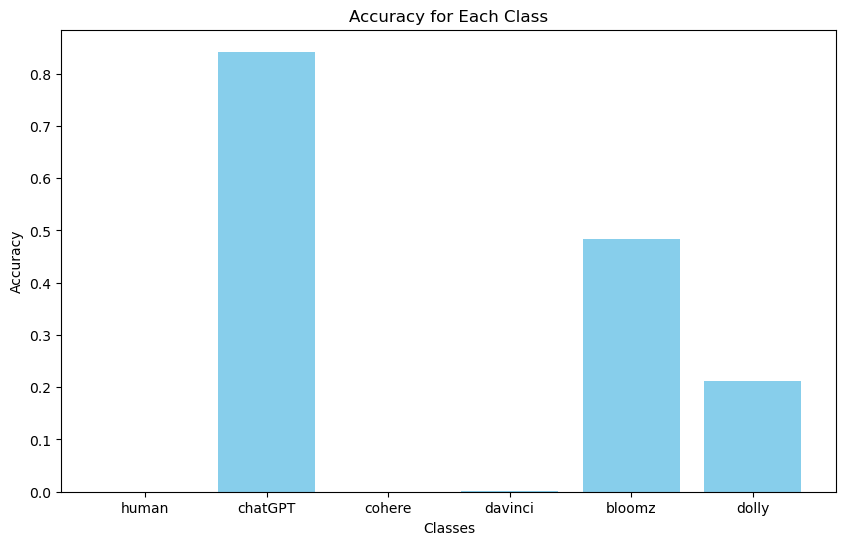

Classification Report:
               precision    recall  f1-score   support

       human       1.00      0.00      0.00       500
     chatGPT       0.19      0.84      0.31       500
      cohere       1.00      0.00      0.00       500
     davinci       0.06      0.00      0.00       500
      bloomz       0.64      0.48      0.55       500
       dolly       0.31      0.21      0.25       500

    accuracy                           0.26      3000
   macro avg       0.53      0.26      0.19      3000
weighted avg       0.53      0.26      0.19      3000



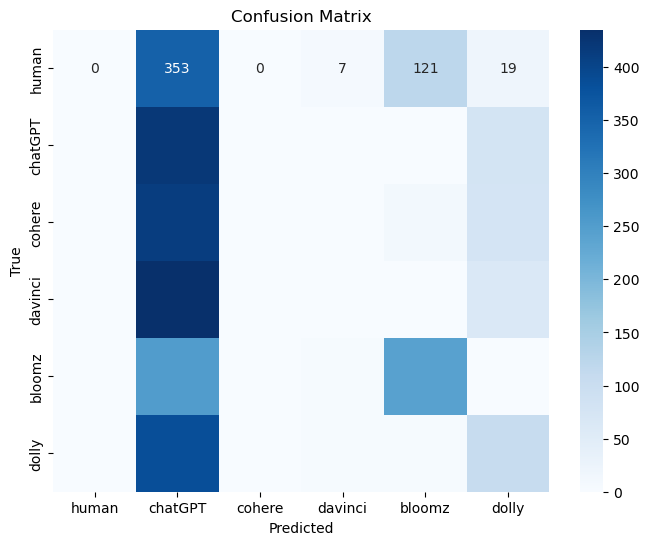

In [36]:
# Example usage
accuracy, class_report, preds = test(test_df, f"model/best/", id2label, label2id)